<a href="https://colab.research.google.com/github/HelmchenLabSoftware/Cascade/blob/master/Demo%20scripts/Calibrated_spike_inference_with_Cascade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CASCADE

## Calibrated spike inference from calcium imaging data using deep networks
Written and maintained by [Peter Rupprecht](https://github.com/PTRRupprecht) and [Adrian Hoffmann](https://github.com/AdrianHoffmann) from the [Helmchen Lab](https://www.hifo.uzh.ch/en/research/helmchen.html).
The project started as a collaboration of the Helmchen Lab and the [Friedrich Lab](https://www.fmi.ch/research-groups/groupleader.html?group=119).

---



This colaboratory notebook runs on servers in the cloud. It uses an algorithm based on deep networks for spike inference (CASCADE, described in this [preprint](https://github.com/HelmchenLabSoftware/Calibrated-inference-of-spiking)). Here, you can test it and use it without any installation on your computer. You just have to sequentially **press the play buttons ("Run cell")** on the left of each box, and the code will be executed.

* If you want to **see the algorithm in action**, just execute the cells without any modifications. Enjoy!

* If you want to **upload your own data**, make predictions and download the saved files, you have to modify the variable names and follow the instructions. Usually no or very little modifications of the code is required.

* If you want to integrate CASCADE into **your local data analysis pipeline**, we suggest you take a look at the [Github repository](https://github.com/HelmchenLabSoftware/Calibrated-inference-of-spiking).

At the end of the notebook, there is a FAQ which answers the most urgent questions (e.g., how do I interpret the results correctly?).

Let's jump in!

##1. Download repository into the Colab Notebook


In [1]:
#@markdown The Github repository with all custom functions, the ground truth datasets and the pretrained models is copied to the environment of this notebook. This will take a couple of seconds.

#@markdown *Note: You can check the code underlying each cell by double-clicking on it.*


!git clone https://github.com/HelmchenLabSoftware/Cascade
import os
os.chdir('Cascade')

Cloning into 'Cascade'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 2066 (delta 9), reused 8 (delta 1), pack-reused 2040
Receiving objects: 100% (2066/2066), 727.16 MiB | 35.96 MiB/s, done.
Resolving deltas: 100% (337/337), done.
Checking out files: 100% (422/422), done.


##2. Import required python packages


In [2]:
#@markdown Downloads packages from public repository, and packages from Cascade.

%%capture
!pip install ruamel.yaml

# standard python packages
import os, warnings
import glob
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import ruamel.yaml as yaml

# cascade2p packages, imported from the downloaded Github repository
from cascade2p import checks
checks.check_packages()
from cascade2p import cascade # local folder
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

##3. Define function to load ΔF/F traces


In [3]:
#@markdown ΔF/F traces must be saved as \*.npy-files (for Python) or \*.mat-files (for Matlab/Python) as a single large matrix named **`dF_traces`** (neurons x time). ΔF/F values of the input should be numeric, not in percent. For different input formats, the code in this box can be modified (it\'s not difficult).

def load_neurons_x_time(file_path):
    """Custom method to load data as 2d array with shape (neurons, nr_timepoints)"""
    
    if file_path.endswith('.mat'):
      traces = sio.loadmat(file_path)['dF_traces']

    elif file_path.endswith('.npy'):
      traces = np.load(file_path, allow_pickle=True).item()['dF_traces']
    
    else:
      print('No appropriate data was found.')
      return
    print(np.nanmean(np.nanstd(traces,axis=1)))
    if np.nanmean(np.nanstd(traces,axis=1)) > 2:
      print('Fluctuations in dF/F are very large, probably dF/F is given in percent. Traces are divided by 100.')
      return traces/100
    else:
        return traces
     
    
  


##4. Select dataset, indicate frame rate and load ΔF/F traces

In [4]:
#@markdown If you are testing the script, you can leave everything unchanged. If you want to apply the algorithm to your own data, you have to upload your data first. You can do this by clicking on the **folder symbol ("Files")** on the left side of the Colaboratory notebook. Next, indicate the path of the uploaded file in the variable **`example_file`**. Finally, indicate the sampling rate of your recordings in the variable **`frame_rate`**.

example_file = "Example_datasets/Multiplane-OGB1-zf-pDp-Rupprecht-7.5Hz/Calcium_traces_01.mat" #@param {type:"string"}

frame_rate = 7.5 #@param {type:"number"}

traces = load_neurons_x_time( example_file )
print('Number of neurons in dataset:', traces.shape[0])
print('Number of timepoints in dataset:', traces.shape[1])



12.146497592217646
Fluctuations in dF/F are very large, probably dF/F is given in percent. Traces are divided by 100.
Number of neurons in dataset: 1005
Number of timepoints in dataset: 260


/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


##5. Plot distribution of noise levels

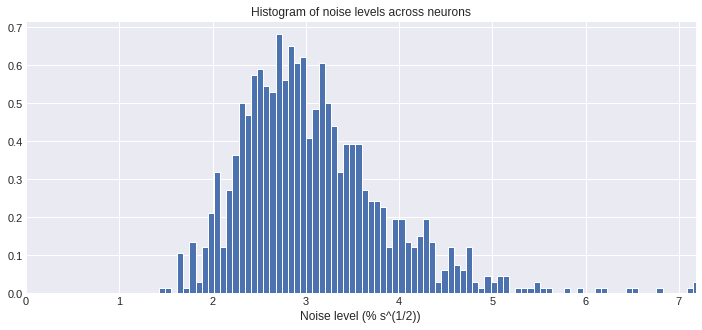

In [5]:
#@markdown For each neuron in the loaded dataset, the noise level will be computed and the distribution across neurons is shown.
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [12, 5]

noise_levels = plot_noise_level_distribution(traces,frame_rate)



##6. Plot randomly selected calcium traces

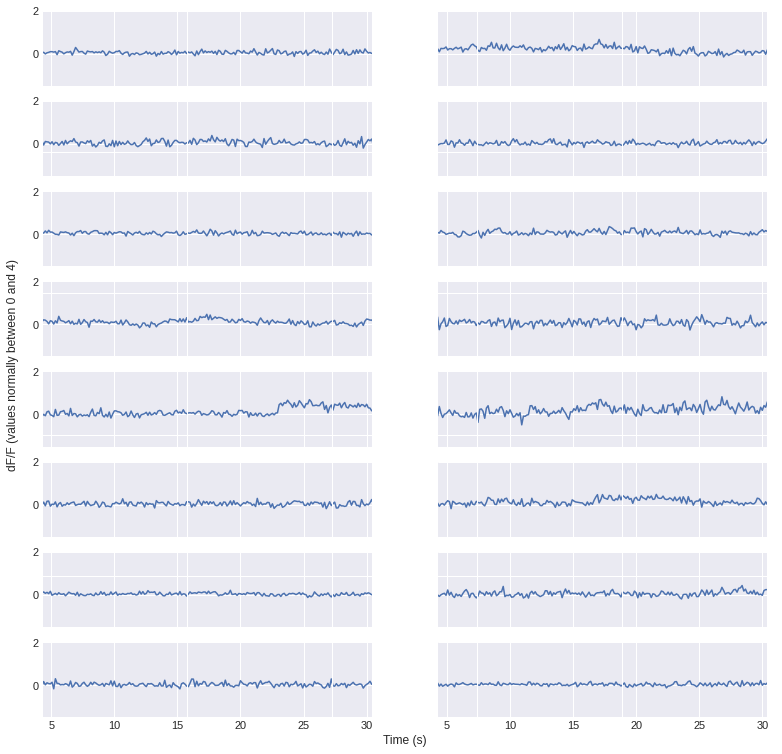

In [6]:
#@markdown This helps to check whether the data have been loaded correctly. If you want to plot specific instead of randomly selected neurons, modify the variable **`neuron_indices`** accordingly.


plt.rcParams['figure.figsize'] = [13, 13]

#np.random.seed(3952)
neuron_indices = np.random.randint(traces.shape[0], size=16)
plot_dFF_traces(traces,neuron_indices,frame_rate)




##7. Select pretrained model

In [7]:
#@markdown Get list of the names of available models.


cascade.download_model( 'update_models',verbose = 1)

yaml_file = open('Pretrained_models/available_models.yaml')
X = yaml.load(yaml_file, Loader=yaml.Loader)
list_of_models = list(X.keys())
print('\n List of available models: \n')
for model in list_of_models:
  print(model)

You can now check the updated available_models.yaml file for valid model names.
File location: /content/Cascade/Pretrained_models/available_models.yaml

 List of available models: 

GCaMP6f_mouse_30Hz_smoothing200ms
OGB_zf_pDp_7.5Hz_smoothing200ms
Universal_5Hz_smoothing200ms
Universal_5Hz_smoothing200ms_causalkernel
Universal_6Hz_smoothing200ms
Universal_6Hz_smoothing200ms_causalkernel
Universal_7.5Hz_smoothing200ms
Universal_7.5Hz_smoothing200ms_causalkernel
Universal_10Hz_smoothing100ms
Universal_10Hz_smoothing100ms_causalkernel
Universal_10Hz_smoothing200ms
Universal_10Hz_smoothing200ms_causalkernel
Universal_12.5Hz_smoothing100ms
Universal_12.5Hz_smoothing100ms_causalkernel
Universal_12.5Hz_smoothing200ms
Universal_12.5Hz_smoothing200ms_causalkernel
Universal_15Hz_smoothing100ms
Universal_15Hz_smoothing100ms_causalkernel
Universal_15Hz_smoothing200ms
Universal_15Hz_smoothing200ms_causalkernel
Universal_17.5Hz_smoothing100ms
Universal_17.5Hz_smoothing200ms
Universal_17.5Hz_smoothin

In [8]:

#@markdown Select and download the model that fits to your dataset (frame rate, training data; see FAQ for more details) and assign to variable **`model_name`**.

model_name = "Universal_7.5Hz_smoothing200ms_causalkernel" #@param {type:"string"}

cascade.download_model( model_name,verbose = 1)

Pretrained model was saved in folder "/content/Cascade/Pretrained_models/Universal_7.5Hz_smoothing200ms_causalkernel"


##8. Predict spike rates from ΔF/F traces

In [10]:
#@markdown If this takes too long, make sure that the GPU runtime is activated (*Menu > Runtime > Change Runtime Type*).

spike_rates = cascade.predict( model_name, traces )




 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 7.5Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 200 milliseconds. 
 

Loaded model was trained at frame rate 7.5 Hz
Given argument traces contains 1005 neurons and 260 frames.
Noise levels (mean, std; in standard units): 3.09, 0.81

Predictions for noise level 2:
	... ensemble 0
8/8 [==============================] - 1s 156ms/step
	... ensemble 1
8/8 [==============================] - 1s 156ms/step
	... ensemble 2
8/8 [==============================] - 1s 166ms/step
	... ensemble 3
8/8 [==============================] - 1s 157ms/step
	... ensemble 4
8/8 [==============================] - 1s 157ms/step

Predictions for noise level 3:
	... ensemble 0
17/17 [==============================] - 3s 185ms/step
	... ensemble 1
17/17 [==============================] - 3s 188ms/step
	... ensemble 2
17/17 [============================

##9. Plot randomly selected example predictions

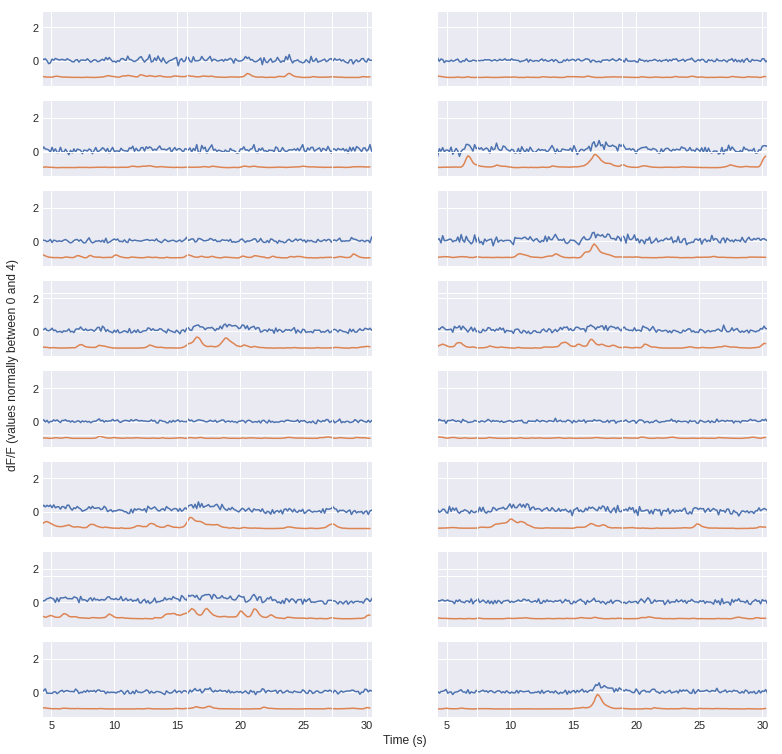

In [11]:
#@markdown By default plots a set of 16 randomly chosen neuronal traces (first seconds).

nb_neurons = 16

neuron_indices = np.random.randint(traces.shape[0], size=nb_neurons)
plot_dFF_traces(traces,neuron_indices,frame_rate,spike_rates,y_range=(-1.5, 3))

##10. Plot noise-matched examples from the ground truth

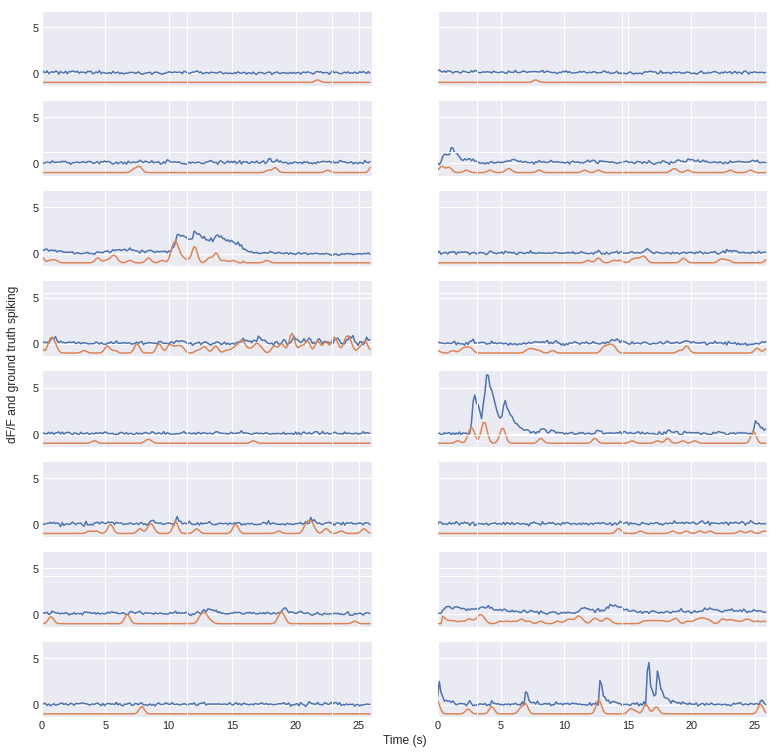

In [12]:
#@markdown Plots randomly drawn excerpts from the ground truth, re-sampled at the same frame rate and noise level as a typical recording of the test dataset.

#@markdown This allows to directly compare **data quality** and **possible artifacts** of training dataset (ground truth) and test dataset (your calcium imaging data). 

median_noise = np.round(np.maximum(2,np.median(noise_levels)))
nb_traces = 16
duration = 26 # seconds
plot_noise_matched_ground_truth( model_name, median_noise, frame_rate, nb_traces, duration )

##11. Save predictions to output file

In [13]:
#@markdown By default saves as variable **`spike_rates`** both to a *.mat-file and a *.npy-file. You can uncomment the file format that you do not need or leave it as it is. 

folder = os.path.dirname(example_file)
save_path = os.path.join(folder, 'predictions_'+os.path.basename(example_file))

# save as mat file
sio.savemat(save_path, {'spike_rates':spike_rates})

save_path = os.path.splitext(save_path)[0]
# save as numpy file
np.save(save_path, spike_rates)


# FAQ
## Frequently Asked Question
<a id='FAQ'></a>
Everything you need to know to properly use the above code, to correctly interpret the results, and much more.

---

#### What does the output of the algorithm mean?

>The output is the estimated probability of action potentials, at the same resolution as the original calcium recording. If you sum over the trace in time, you will get the estimated **number of action potentials**. If you multiply the trace with the frame rate, you will get an estimate of the instantaneous **firing rate**.

#### How large would a single spike be?
>This depends on your frame rate (Hz) and on the smoothing (standard deviation, milliseconds) of your model. Use the following script to compute the spike probability shape for given parameters.


In [15]:
from scipy.ndimage.filters import gaussian_filter
import numpy as np

sampling_rate = 7.5 #@param {type:"number"}
smoothing = 200 #@param {type:"number"}

# find out empirically  how large a single AP is
single_spike = np.zeros(1001,)
single_spike[501] = 1
single_spike_smoothed = gaussian_filter(single_spike.astype(float), sigma=smoothing/1e3*sampling_rate)

gaussian_amplitude = np.round(np.max(single_spike_smoothed)*1000)/1000

gaussian_width = np.round(2*np.sqrt(2*np.log(2))*smoothing/1e3*100)/100


print('A single spike in the predictions will have an amplitude of '+str(gaussian_amplitude)+' and a width (FWHM) of '+str(gaussian_width)+' seconds.')


A single spike in the predictions will have an amplitude of 0.266 and a width (FWHM) of 0.47 seconds.


#### How precise and good are my predictions? 

>This depends mainly on the **shot noise level** of your dataset. If you want to compute how good the chosen model generalizes to unseen data for a given noise level, check out the Github repository and use the demo script XYZ.
>
>If you want to get a good idea about the quality of predictions, check out **Figures 3 and 4**, as well as the corresponding supplementary figures in the paper/preprint [link].

#### Why is the output of the algorithm a probability, why not discrete spikes?

>Good question! We think that providing spike times instead of spiking probabilities is misleading, since it suggests a false precision and certainty of the spiking estimates. In addition, we found (**Fig. SXX** in the preprint) that single-spike precision could not achieved with any of the ground truth datasets.
>
>However, for some cases, discrete spikes still might be a good approach. We provide a Python function that converts the spiking probability into discrete spikes (**demo_XXX** on Github).


#### Why are the first and last datapoints of the predictions NaNs?

>The deep network uses a window that looks at the calcium trace around the current time point to better understand the context of the current time point. For the first and last points in time, the network is unable to look into the environment and therefore gives back NaNs. If the window size of the network is 64 datapoints (which is the default), the first and last 32 time points will be NaNs.


#### I get a certain noise level for my recordings. What is good or bad?

>For an illustration of different noise levels, check out Fig. SXX in the preprint. To give an example, the Allen Brain Observatory Visual Coding dataset is of very high imaging quality, with noise levels around **1, which is very good** (unit is percent x sqrt(seconds)). A noise level of **3-4 is still decent**, especially for population imaging with many neurons. Noise levels **above 5 indicates rather poor signal** levels. For a definition of the noise level, check out the Methods of the preprint.
>
>However, even for excellent shot noise levels, the recording quality can be bad due to bad imaging resolution, **neuropil contamination** and, most importantly, **movement artifacts**. See Fig. S10 in the preprint and the associated text as well as the Discussion for more details .


#### How do I select an appropriate model for my data?

> Each model is trained on a resampled ground truth dataset. The training dataset is resampled at the desired frame rate and at multiple noise levels. The model automatically chooses the model with matching noise-levels for each neuron. You only have to select the correct frame rate (which is indicated in the model name).
>
>If you do not have a specific ground truth for your dataset, it is typically best (see Fig. 4 and the associated discussion in the paper) to use a model that has been trained on all available datasets (called 'Universal Model').
>
>There are two additional model specifications that you can choose, "causal" kernels and "smoothing". The choice of these specifications does not make a model better or worse, but better or less well suited for your needs. See the following two questions!

#### What does the "smoothing" for some of the models mean?

> The ground truth which has been used to train the model has been slightly smoothed with a Gaussian kernel. This is a processing step which helps the deep network to learn quicker and more reliably. However, this also means that the predictions will be smoothed in a similar fashion. How to choose these parameters optimally?
>
> From our experience, at a frame rate of 7.5 Hz, a smoothing kernel with standard deviation of 200 ms is appropriate. At 30 Hz, a smoothing kernel of 50 ms works well. If the calcium imaging quality is not ideal, it can make sense to increase the smoothing kernel standard deviation. In the end, it is always a trade-off between reliability and optimal learning (more smoothing) and temporal precision (less smoothing of the ground truth).
>
> If you use our suggested default specifications, you should be good!


#### What does the "causal" mean for some of the models?

> By default, the ground truth is smoothed symmetrically in time. This means, also the predicted spike probabilities are symetrically distributed in time around the true time point. In some cases, this can be a problem because this predicts non-zero neuronal spiking probability before the calcium event had even started. Especially when you want to analyze stimulus-triggered activity patterns, this is an important issue and a common problem for all deconvolution algorithms.
> 
> However, if the ground truth is smoothed not with a symmetric Gaussian but with a smooth causal kernel, this limitation can be circumvented (discussed in detail in Fig. SXX in the preprint), and spiking activity is almost exclusively assigned to time points after the calcium event started. It must be noted that this reliable causal re-assignment of activity works well for high-quality datasets, but in case of higher noise levels, any deconvolution algorithm will assign activity to non-causal time points. Good to keep in mind when you interpret your results!


#### None of the models is good for me. What can I do?

> First of all, is this really true? For example, if you have recorded at 30.5 Hz, you can also use a model trained at 30 Hz imaging rates. A deviation by less than 5\% of the imaging rate is totally okay in our experience!
>
> If however you want to use an entirely different model, for example a model trained at a sampling rate of 2 Hz, or a model only trained with a specific ground truth dataset, you have two options. 1) You go to the [Github page](https://github.com/HelmchenLabSoftware/Cascade) and follow the instructions on how to train you own model. This can be done even without GPU-support, but it will take some time (on the other hand, you only have to do this once). 2) You contact us via [e-Mail](p.t.r.rupprecht+cascade@gmail.com) and tell us what kind of model you would like to have. We will train it for you and upload it to our repository. Not only you, but everybody will then be able to use it further on.



#### I have my own ground truth dataset. How can I use it?

> You have two options.
>
> Either you process the data yourself. You can inspect the ground truth datasets, which consist of Matlab structs saved as a file for each neuron from the [ground truth](https://github.com/HelmchenLabSoftware/Calibrated-inference-of-spiking/tree/master/Ground_truth). If you process your ground truth recordings into the same format, you can use it as a training set and train the model yourself. All instructions are indicated at the Github repository.
>
> Or you can contact us, and we help to process your dataset if it meets certain quality standards. We can process raw calcium and ephys recordings, but of course extracted dF/F traces and spike times would be even better. Yes, we will do the work for you. But only under the condition that the processed dataset will then be integrated into the published set of ground truth datasets, where it is openly accessible to everybody. Please get in touch with us to discuss options on how to get credit for the recording of the dataset, which we will discussed case by case.

#### I want to use my own ground truth dataset, but I don't want to share it.

> As mentioned, you can process the ground truth dataset yourself. However, we will only help you with the dataset is made public afterwards.


#### Can I use the algorithm also locally, *e.g.*, within [CaImAn](https://github.com/flatironinstitute/CaImAn), or in my own pipeline?

> Sure! We have done this ourselves with CaImAn and our custom analysis pipelines. Your starting point to do this will not be this Colaboratory Notebook, but rather the [Github repository](https://github.com/HelmchenLabSoftware/Cascade). Check out the demo scripts. They are very easy to understand and will show you which functions you have to use and how. If you have successfully used this Colaboratory Notebook, understanding the demo scripts will be a piece of cake.

#### I would like to look at the ground truth data.

> We actually recommend this to anybody who is doing calcium imaging at cellular resolution. Looking at the ground truth data of simultaneous calcium and juxtacellular recording is very enlightening. In the [Github repository](https://github.com/HelmchenLabSoftware/Cascade), you will find scripts both for Python and Matlab to conveniently visualize ground truth recordings. Just download the Github repository and use the scripts in Matlab or Python (to be done XYZ).




#### Which reference should I cite?

> Please cite the preprint [link] as a reference.
